In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import PySimpleGUI as sg 
import easygui

In [2]:
def pinta_laberinto(laberinto, matriz, mostrar = False):
       
    clear_output(wait=True)
    plt.figure(figsize = (laberinto.shape[0]/2.5, laberinto.shape[1]/2.5))
    plt.imshow(laberinto, cmap='hot')
    plt.show()
        

In [3]:
def tamaño_laberinto():

    layout = [[sg.Text("¿Cómo quieres de alto el laberinto? \n \nPrueba con 50, por ejemplo")],    
              [sg.Input()],
              [sg.Button('Ok')] ]   
    sg.theme('Reddit')
    window = sg.Window('Selección de alto ', layout, finalize = True)
    window.BringToFront()
    event, alto = window.read()
    window.close()
        
    layout = [[sg.Text("¿Cómo quieres de ancho el laberinto? \n \nPrueba con 100, por ejemplo")],    
              [sg.Input()],
              [sg.Button('Ok')] ]    
    sg.theme('Reddit')
    window = sg.Window('Selección de ancho ', layout, finalize = True)
    window.BringToFront()
    event, ancho = window.read()
    window.close()
    
    try:
    
        alto = int(alto[0])
        ancho = int(ancho[0])
        
    except:
        
        print("Debes indicar un número para el tamaño")
        alto, ancho = tamaño_laberinto()
    
    return alto, ancho

In [8]:
def construye_laberinto(muro = 0, pasillo = 10, hormiguero = 5, comida = 7):

    '''
    Lo primero que debemos hacer es construir un entorno en el que podamos poder a prueba la colonia de hormigas
    Este punto es muy importante. La manera en la que construyamos el laberinto puede hacer que sea muy fácil de resolver (solo haya una solución)
    Queremos generar laberintos aleatorios que puedan tener entre 0 y N soluciones
    Por otro lado, el cómo hagamos los caminos puede derivar en "rotondas" o "plazas" 
    En estas rotondas o plazas será donde la hormiga tendrá más dificultad a la hora de orientarse
    
    '''

    alto, ancho = tamaño_laberinto()
    laberinto = np.zeros((alto, ancho))
    
    # Construimos los caminos del laberinto
    for camino in range(int(round((alto * ancho)/ 5))):

        inicio_ok = False
        while inicio_ok == False:

            fila = np.random.randint(low = 1, high = alto-1, size = 1)
            columna = np.random.randint(low = 1, high = ancho -1, size = 1)

            if laberinto[fila, columna] == muro:
                inicio_ok = True
                
                if camino == 0:
                    laberinto[fila, columna] = hormiguero
                else:
                    laberinto[fila, columna] = pasillo

        # A partir de la posición inicial, comenzamos a "tirar muros"
        # Condiciones de parada: que llegue a un pasillo o al muro exterior    

        direccion = np.random.randint(low = 1, high = 4, size = 1)    
        stop = False
        pos_fila = fila
        pos_col = columna
        longitud = 0

        while stop == False:

            if direccion == 1: # subimos

                # Comprobamos que la nueva posición es un muro y que no está en los límites
                if (laberinto[pos_fila - 1, pos_col] == muro and (pos_fila - 1) != 0 and laberinto[pos_fila, pos_col +1] == muro and laberinto[pos_fila, pos_col -1] == muro and longitud < round(laberinto.shape[0]/4)):
                    laberinto[pos_fila - 1, pos_col] = pasillo
                    pos_fila = pos_fila - 1
                    longitud += 1                  
                else:
                    stop = True

            elif direccion == 2: # bajamos

                # Comprobamos que la nueva posición es un muro y que no está en los límites
                if (laberinto[pos_fila + 1, pos_col] == muro and (pos_fila + 1) != laberinto.shape[0]-1 and laberinto[pos_fila, pos_col +1] == muro and laberinto[pos_fila, pos_col -1] == muro and longitud < round(laberinto.shape[0]/4)):
                    laberinto[pos_fila + 1, pos_col] = pasillo
                    pos_fila = pos_fila + 1
                    longitud += 1       
                else:
                    stop = True

            elif direccion == 3: # vamos a la derecha

                # Comprobamos que la nueva posición es un muro y que no está en los límites
                if (laberinto[pos_fila, pos_col + 1] == muro and (pos_col + 1) != laberinto.shape[1]-1 and laberinto[pos_fila +1, pos_col] == muro and laberinto[pos_fila-1, pos_col] == muro and longitud < round(laberinto.shape[0]/4)):
                    laberinto[pos_fila, pos_col + 1] = pasillo
                    pos_col = pos_col + 1
                    longitud += 1    
                else:
                    stop = True

            else: # vamos a la izquierda

                # Comprobamos que la nueva posición es un muro y que no está en los límites
                if (laberinto[pos_fila, pos_col - 1] == muro and (pos_col - 1) != 0 and laberinto[pos_fila +1, pos_col] == muro and laberinto[pos_fila-1, pos_col] == muro and longitud < round(laberinto.shape[0]/4)):
                    laberinto[pos_fila, pos_col - 1] = pasillo
                    pos_col = pos_col - 1
                    longitud += 1      
                else:
                    stop = True
    
    # La última posición será la comida
    laberinto[fila, columna] = comida
       
    # La relación entre la feromona inicial y la feromono depositada (en función a la distancia) debe estar en perfecto equilibrio o el enjambre no funcionará
    feromona_inicial = 1

    # Depositamos la feromona inicial en todas las casillas que no sean muros
    matriz_feromonas = np.zeros((laberinto.shape[0], laberinto.shape[1]))
    matriz_feromonas[laberinto != muro] = feromona_inicial
    
    # Depositamos una feromona muy alta en la comida, para que si pasan a su lado, la vean.
    matriz_feromonas[laberinto == comida] = feromona_inicial*1000
    
    # Por último, pintamos el laberinto terminado
    pinta_laberinto(laberinto, matriz= matriz_feromonas, mostrar = False)
    
    # Creamos una matriz_fiel para la hormiga fiel
    matriz_fiel = np.copy(laberinto)
    matriz_fiel[laberinto == muro] = 1000
    matriz_fiel[laberinto == pasillo] = 1000
    matriz_fiel[laberinto == hormiguero] = 1000
    matriz_fiel[laberinto == comida] = 0
    
    return laberinto, matriz_feromonas, matriz_fiel

## Ejecutamos el programa

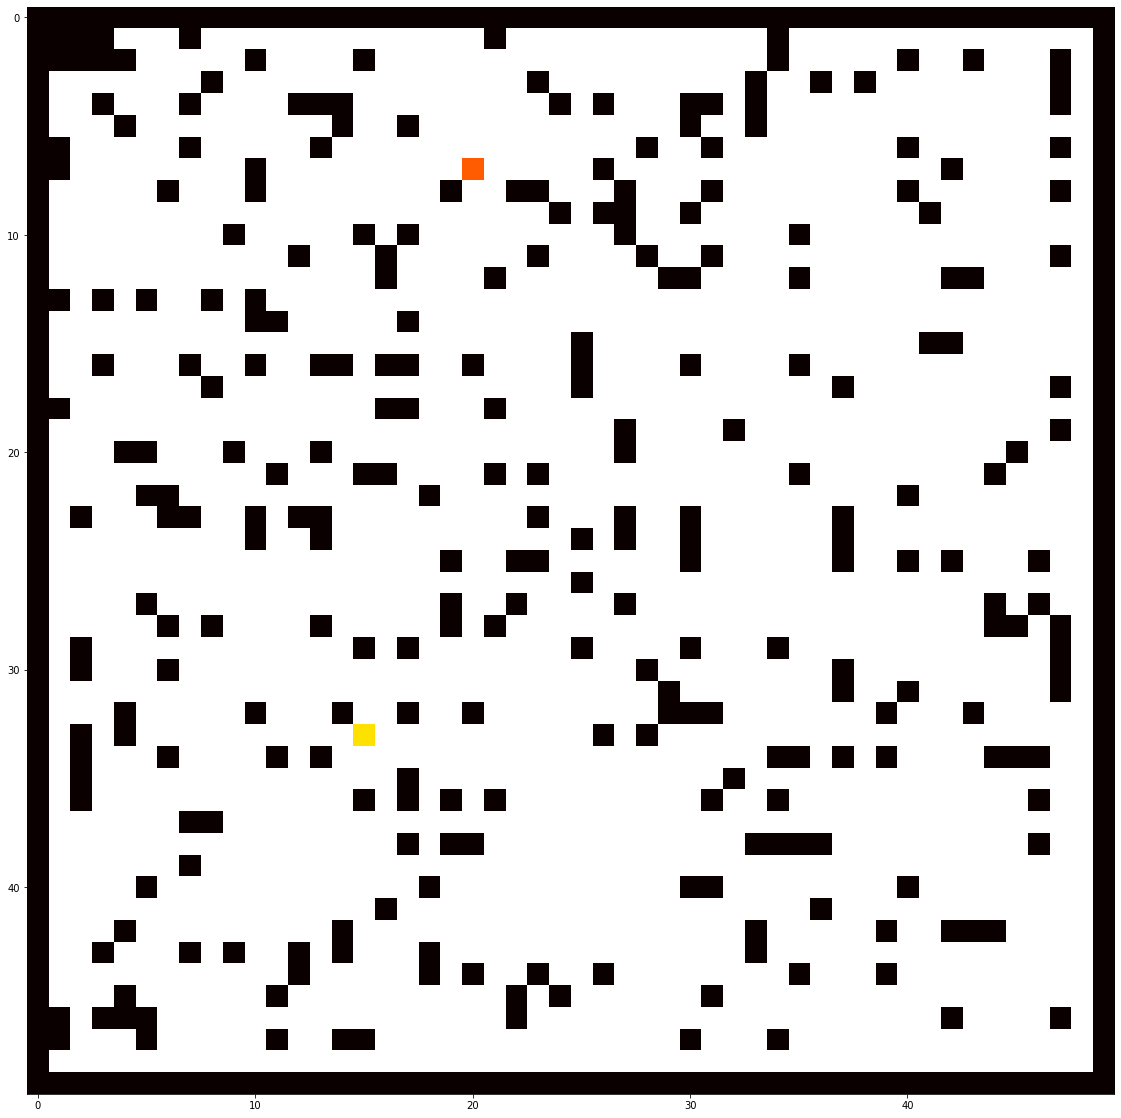

In [9]:
muro = 0
pasillo = 10
hormiguero = 5
comida = 7
hormiga = 2

# Construimos el laberinto y depositamos las feromonas iniciales
laberinto, matriz_feromonas, matriz_fiel = construye_laberinto(muro = muro, pasillo = pasillo, hormiguero = hormiguero, comida = comida)
    